In [525]:
import pandas as pd

In [526]:
rating = pd.read_csv('jester_ratings.dat',sep='\t',header=None)
rating = rating[[0,2,4]]
rating.columns = ['id', 'Num','rating']
print(rating.shape)

(1761439, 3)


In [527]:
with open('jester_items.dat') as f:
    n=0
    final=[]
    for line in f:
        if n ==0:
            l = line[:-1]
        else:
            l = l +  line[:-1]
        n+=1
        if line=='\n':
            final.append(l)
            n=0

In [536]:
import numpy as np
data = pd.DataFrame({'contents': final,
                   'Num' : range(1,len(final)+1)})
data.contents = data.contents.apply(lambda x: x.replace('<p>',''))
data.contents = data.contents.apply(lambda x: x.replace('</p>',''))
data.contents = data.contents.apply(lambda x: x.replace('<br />',''))
data.contents = data.contents.apply(lambda x: x.replace('&quot;',''))
data.contents = data.contents.apply(lambda x: x.replace('&#039;','\''))
data = data.drop(132)
data = data.reset_index(drop=True)

In [537]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(data['contents'])

In [538]:
tfidf_matrix.shape

(149, 2123)

In [539]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [540]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return metadata['title'].iloc[movie_indices]


In [541]:
cosine_sim.shape

(149, 149)

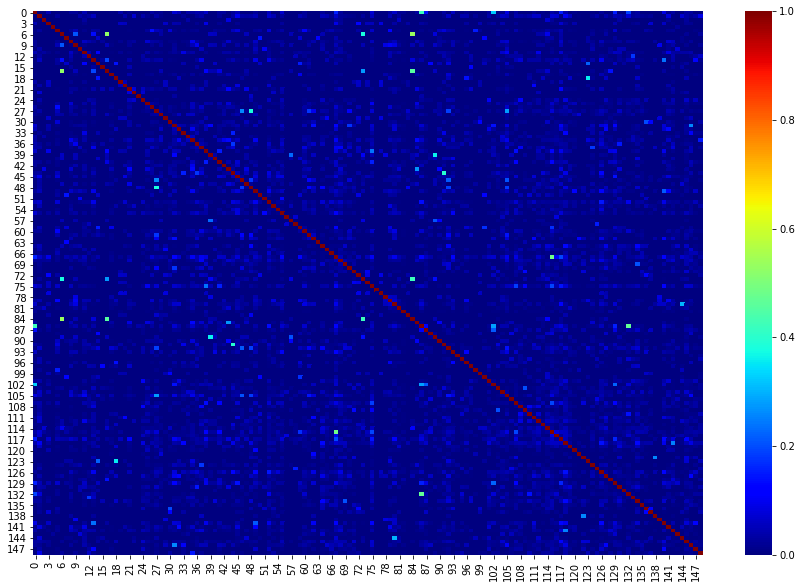

In [579]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,10))
sns.heatmap(cosine_sim,cmap='jet')

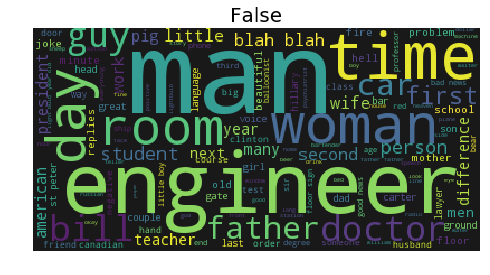

In [543]:
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud ,STOPWORDS
stopword=set(STOPWORDS)

def word_cloud(df, column, weight=False, label=False, bg='black',cmap='viridis'):
    df[column] = df[column].apply(lambda x:x.lower())
    
    if weight == False:
        df_word = df[column].apply(lambda x: word_tokenize(x)).values 
    else:
        df_word = df[column].apply(lambda x: word_tokenize(x)).values * (df.score +1 )
        df_word = df_word.values
        
    t = [j for i in range(len(df_word)) for j in df_word[i]]
    t2 = np.asarray([x for 
                     x in t if x not in ['business','question','businesse'
                                       'advice','need','help','small','company',
                                      'looking','new','owner',
                                      'one','also','will','people','thing','anyone',
                                        'advice','idea','feedback']])
    
    tagged = nltk.pos_tag(t2)
    kk =(np.array([x[1] for x in tagged]) =='NN') | (np.array([x[1] for x in tagged]) =='JJ') | (np.array([x[1] for x in tagged]) =='NNP') | (np.array([x[1] for x in tagged]) =='NNS') | (np.array([x[1] for x in tagged]) =='NNPS')
    total = t2[kk]
    
    wc= WordCloud(collocations=True,background_color=bg,max_words=2000,stopwords=stopword)
    wc.generate(" ".join(total))

    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(label, fontsize=20) #'
    plt.imshow(wc.recolor(colormap= cmap , random_state=17), alpha=0.9)
    plt.show()
    
    return(wc)

total=word_cloud(data,'contents')

## Visualization

In [544]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3


For the purposes of this walkthrough, imagine that I have lists:
- 'contents': the contents of the Jokes matched to the 'titles' order

In the full workbook that I posted to github you can walk through the import of these lists, but for brevity just keep in mind that for the rest of this walk-through I will focus on using these two lists. Of primary importance is the 'contents' list; 'Number' is mostly used for labeling purposes.

## Stopwords, stemming, and tokenizing

In [545]:
stopwords = nltk.corpus.stopwords.words('english')

In [546]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [547]:
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [548]:
totalvocab_stemmed = []
totalvocab_tokenized = []
contents=data.contents.values
for i in contents:
    allwords_stemmed = tokenize_and_stem(i) 
    totalvocab_stemmed.extend(allwords_stemmed) 
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)


In [549]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 10227 items in vocab_frame


## Tf-idf and document similarity

In [589]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=200000, stop_words='english',
                              use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(data.contents) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

(149, 10453)


In [590]:
terms = tfidf_vectorizer.get_feature_names()
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

## Visualizing document clusters¶
In this section, I demonstrate how you can visualize the document clustering output using matplotlib and mpld3 (a matplotlib wrapper for D3.js).

First I define some dictionaries for going from cluster number to color and to cluster name. I based the cluster names off the words that were closest to each cluster centroid.

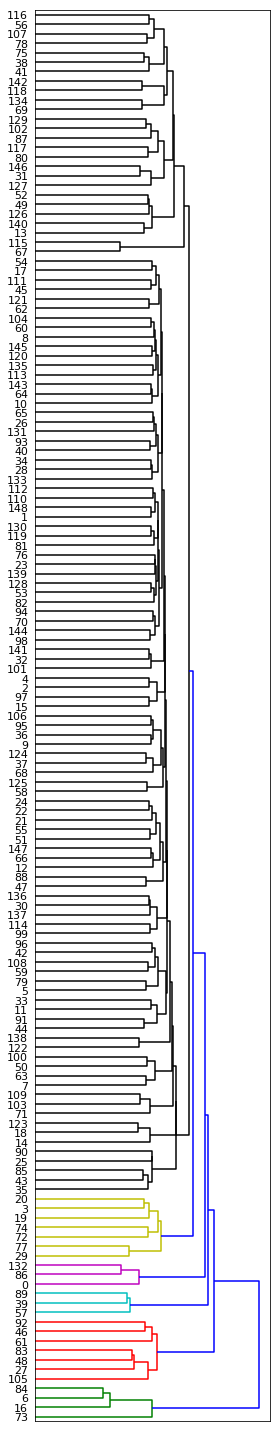

In [611]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist)
fig, ax = plt.subplots(figsize=(4, 20)) 
ax = dendrogram(linkage_matrix, orientation="right", labels=data.index.values, leaf_font_size=11);

plt.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
plt.tight_layout() 

plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [625]:
print(contents[92])
print(contents[46])
print(contents[61])
print(contents[83])
print(contents[48])
print(contents[27])
print(contents[105])

93:reaching the end of a job interview, the human resources person asked a young engineer fresh out of stanford,and what starting salary were you looking for?the engineer said, in the neighborhood of $125,000 a year, depending on the benefits package.the interviewer said, well, what would you say to a package of 5-weeks vacation, 14 paid holidays, full medical and dental, company matching retirement fund to 50% of salary, and a company car leased every 2 years--say, a red corvette?the engineer sat up straight and said, wow! are you kidding?and the interviewer replied, yeah, but you started it.
47:there was an engineer who had an exceptional gift for fixing all things mechanical. after serving his company loyally for over 30 years, he happily retired. several years later the company contacted him regarding a seemingly impossible problem they were having with one of their multi-million dollar machines. they had tried everything and everyone else to get the machine fixed, but to no avail.

In [622]:
print(contents[84])
print(contents[6])
print(contents[16])
print(contents[73])

85:q: how many presidents does it take to screw in a light bulb?a: it depends upon your definition of screwing a light bulb.
7:how many feminists does it take to screw in a light bulb?that's not funny.
17:how many men does it take to screw in a light bulb?one. men will screw anything.
74:q: how many stalkers does it take to change a light bulb?a: two. one to replace the bulb, and the other to watch it day and night.


In [623]:
print(contents[89])
print(contents[39])
print(contents[57])

90:q: how many programmers does it take to change a lightbulb?a: none! that's a hardware problem...
40:how many irishmen does it take to change a lightbulb?two. one to hold the lightbulb and the other to drink until the room spins.
58:how many teddy bears does it take to change a lightbulb?it takes only one teddy bear, but it takes a whole lot of lightbulbs.


In [624]:
print(contents[132])
print(contents[86])
print(contents[0])

134:an artist asked the gallery owner if there had been any interest in his paintings currently on display. i've got good news and bad news, the owner replied. the good news is that a gentleman inquired about your work and wondered if it would appreciate in value after your death. when i told him it would, he bought all fifteen of your paintings.that's wonderful! the artist exclaimed. what's the bad news?with concern, the gallery owner replied:the guy was your doctor.
87:a man who recently completed a routine physical examination receives a phone call from his doctor. the doctor says, i have some good news and some bad news. the man says, okay, give me the good news first. the doctor says, the good news is: you have 24 hours to live. the man replies, shit! that's the good news? then what's the bad news?the doctor says, the bad news is: i forgot to call you yesterday.
1:a man visits the doctor. the doctor says, i have bad news for you. you have cancer and alzheimer's disease.the man rep

In [483]:
data['contents'][2]

"3:q. what's 200 feet long and has 4 teeth?a. the front row at a willie nelson concert."

/Users/ryan/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


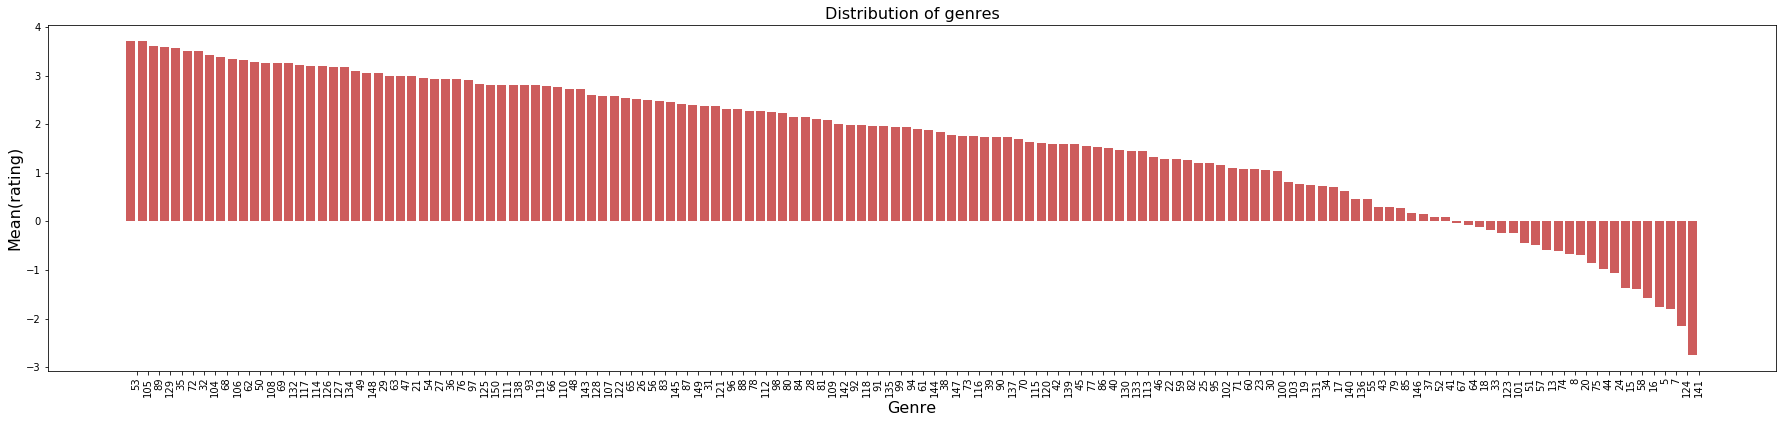

In [664]:
x = np.arange(140)
f = plt.figure(figsize=(30,6))
series = rating.groupby('Num').mean()['rating'].sort_values(ascending=False)
ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(x, series.values ,color='indianred')
ax.set_xticks(x+0.5)
ax.set_xticklabels(series.index,rotation=90,fontsize=10)
plt.xlabel('Genre',fontsize=16)
plt.ylabel('Mean(rating)',fontsize=16)
plt.title('Distribution of genres',fontsize=16)
f.show()

/Users/ryan/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


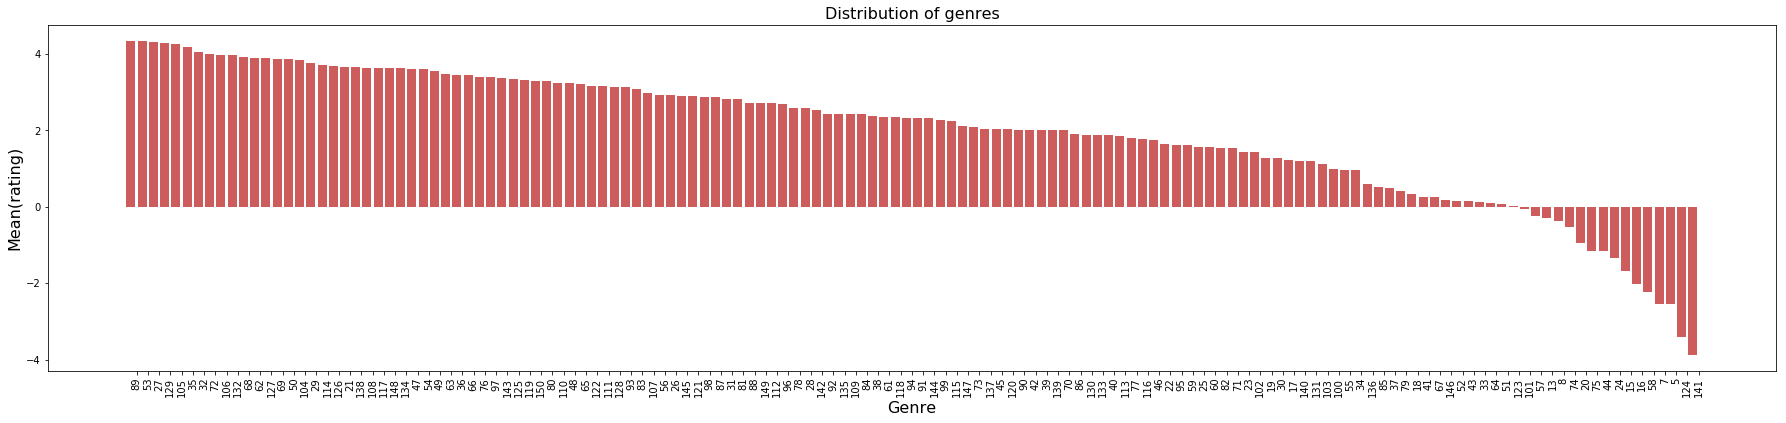

In [667]:
x = np.arange(140)
f = plt.figure(figsize=(30,6))
series = rating.groupby('Num').median()['rating'].sort_values(ascending=False)
ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(x, series.values ,color='indianred')
ax.set_xticks(x+0.5)
ax.set_xticklabels(series.index,rotation=90,fontsize=10)
plt.xlabel('Genre',fontsize=16)
plt.ylabel('Mean(rating)',fontsize=16)
plt.title('Distribution of genres',fontsize=16)
f.show()

In [666]:
count_series  = rating.groupby('Num').count()['rating'].sort_values(ascending=False)

In [670]:
contents[139]

"141:jack bauer can get mcdonald's breakfast after 10:30."

In [671]:
contents[123]

"124:person 1: hey, wanna hear a great knock-knock joke?person 2: sure, what is it?person 1: okay, you start.person 2: knock-knock.person 1: who's there?person 2: ...person 1: hah!"